In [1]:
import argparse
import cv2
import numpy as np
import os
import torch
import torch.nn.functional as F
from torchvision.transforms import Compose
from tqdm import tqdm
from path import Path
from path import Path
from tqdm.contrib import tzip

from depth_anything.dpt import DepthAnything
from depth_anything.util.transform import Resize, NormalizeImage, PrepareForNet



/root/miniconda3/envs/depth-anything/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
def RMSE_func(gt,pred):
    return np.sqrt(np.mean((gt-pred)**2))

def MAE_func(gt,pred):
    return abs(gt-pred).mean()


def Rel_func2(gt,pred):
    """rel in paper SimCol3D using median

    Args:
        gt (_type_): _description_
        pred (_type_): _description_

    Returns:
        _type_: _description_
    """
    mask = gt>0
    return np.median(abs(gt-pred)/(gt+1e-5))



In [5]:
# 加载模型
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

depth_anything = DepthAnything.from_pretrained('./checkpoints/depth_anything_vitl14', local_files_only=True)

transform = Compose([
        Resize(
            width=518,
            height=518,
            resize_target=False,
            keep_aspect_ratio=True,
            ensure_multiple_of=14,
            resize_method='lower_bound',
            image_interpolation_method=cv2.INTER_CUBIC,
        ),
        NormalizeImage(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        PrepareForNet(),
    ])


/root/miniconda3/envs/depth-anything/lib/python3.9/site-packages/torch/cuda/__init__.py:141: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11070). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0
xFormers not available
xFormers not available


Loading weights from local directory


In [10]:

def infer(filename):
    raw_image = cv2.imread(filename)
    image = cv2.cvtColor(raw_image, cv2.COLOR_BGR2RGB) / 255.0
    
    h, w = image.shape[:2]
    
    image = transform({'image': image})['image']
    image = torch.from_numpy(image).unsqueeze(0).to(DEVICE)
    
    with torch.no_grad():
        depth = depth_anything(image)
    
    depth = F.interpolate(depth[None], (h, w), mode='bilinear', align_corners=False)[0, 0]
    depth = (depth - depth.min()) / (depth.max() - depth.min())
    depth = depth.cpu().numpy()
    
    return depth

### 推理图片

In [7]:
# 加载图片

root_path = Path("/root/autodl-tmp/datasets/SimCol")
scenes = []

with open(root_path/'all.txt') as f:
    lines = f.readlines()
for line in lines:
    line = line[:-1]
    scenes.append(root_path/line)

print(type(scenes[0]))


<class 'path.Path'>


(475, 475)


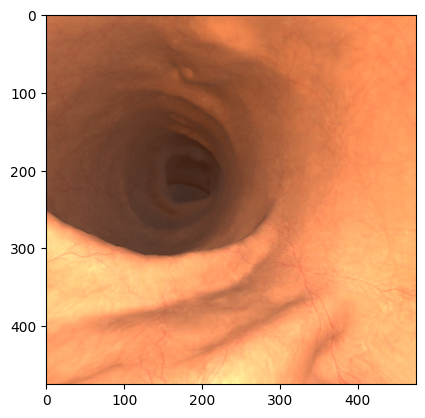

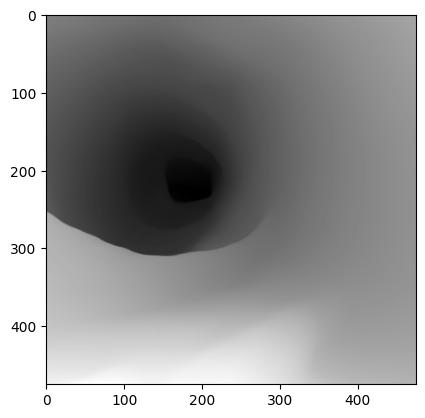

In [12]:
import matplotlib.pyplot as plt

pred = infer("/root/autodl-tmp/datasets/SimCol/SyntheticColon_I/Frames_S1/FrameBuffer_0002.png")
print(pred.shape)

plt.imshow(plt.imread("/root/autodl-tmp/datasets/SimCol/SyntheticColon_I/Frames_S1/FrameBuffer_0002.png"))
plt.figure()
plt.imshow(pred, cmap='gray')


In [16]:
RMSEs, MAEs, AbsRels = [], [], []

for scene in scenes[:1]:
    print("=> processing ", scene)
    rgbs = sorted(scene.listdir("F*.png"))
    gts = sorted( (scene/'depth_gt').listdir("*.npy") )
    
    for rgb_name,gt_name in tzip(rgbs,gts):
        gt_depth = np.load(gt_name)
        pred_depth = 1.0 - infer(rgb_name)

        scale = np.median(gt_depth)/np.median(pred_depth)
        pred_depth *= scale

        RMSEs.append(RMSE_func(gt_depth,pred_depth))
        MAEs.append(MAE_func(gt_depth,pred_depth))
        AbsRels.append(Rel_func2(gt_depth,pred_depth))


/tmp/ipykernel_111915/401128939.py:5: DeprecationWarning: .listdir is deprecated; use iterdir
  rgbs = sorted(scene.listdir("F*.png"))
/tmp/ipykernel_111915/401128939.py:6: DeprecationWarning: .listdir is deprecated; use iterdir
  gts = sorted( (scene/'depth_gt').listdir("*.npy") )


=> processing  /root/autodl-tmp/datasets/SimCol/SyntheticColon_I/Frames_S15


  0%|          | 0/1201 [00:00<?, ?it/s]

100%|██████████| 1201/1201 [1:29:56<00:00,  4.49s/it]


In [17]:
print("=> RMSE is ", sum(RMSEs)/len(RMSEs))
print("=> MAE is ", sum(MAEs)/len(MAEs))
print("=> AbsRel is ", sum(AbsRels)/len(AbsRels))

=> RMSE is  8.312208053526486
=> MAE is  5.1197104110234
=> AbsRel is  0.15721975583792164


### 从文件中读取并统计

In [14]:
import matplotlib.pyplot as plt

def read_scene(lines, start):
    RMSE, MAE, AbsRel = [], [], []
    names = []
    
    name = lines[start][:-1]
    
    start += 2
    line = lines[start][:-1]
    line = line[1:-1]
    RMSE = line.split(", ")
    RMSE = [float(i) for i in RMSE]
    # print(RMSE)
    
    start += 2
    line = lines[start][:-1]
    line = line[1:-1]
    MAE = line.split(", ")
    MAE = [float(i) for i in MAE]
    # print(MAE)
    
    start += 2
    line = lines[start][:-1]
    line = line[1:-1]
    AbsRel = line.split(", ")
    AbsRel = [float(i) for i in AbsRel]
    # print(AbsRel)
    
    return start, name, RMSE,MAE,AbsRel

with open("all.txt", 'r') as f:
    lines = f.readlines()

RMSE_scenes, MAE_scenes, AbsRel_scenes = [], [], []
names = []
start = 3
while(start < len(lines)):
    start,name, RMSE,MAE,AbsRel = read_scene(lines, start)
    names.append(name)
    RMSE_scenes.append(RMSE)
    MAE_scenes.append(MAE)
    AbsRel_scenes.append(AbsRel)
    start += 4
    

/root/autodl-tmp/datasets/SimCol/SyntheticColon_I/Frames_S15
/root/autodl-tmp/datasets/SimCol/SyntheticColon_I/Frames_S7
/root/autodl-tmp/datasets/SimCol/SyntheticColon_I/Frames_S12
/root/autodl-tmp/datasets/SimCol/SyntheticColon_I/Frames_S13
/root/autodl-tmp/datasets/SimCol/SyntheticColon_I/Frames_S1
/root/autodl-tmp/datasets/SimCol/SyntheticColon_I/Frames_S4
/root/autodl-tmp/datasets/SimCol/SyntheticColon_I/Frames_S3
/root/autodl-tmp/datasets/SimCol/SyntheticColon_I/Frames_S2
/root/autodl-tmp/datasets/SimCol/SyntheticColon_I/Frames_S11
/root/autodl-tmp/datasets/SimCol/SyntheticColon_I/Frames_S14
/root/autodl-tmp/datasets/SimCol/SyntheticColon_I/Frames_S9
/root/autodl-tmp/datasets/SimCol/SyntheticColon_I/Frames_S6
/root/autodl-tmp/datasets/SimCol/SyntheticColon_I/Frames_S8
/root/autodl-tmp/datasets/SimCol/SyntheticColon_I/Frames_S5
/root/autodl-tmp/datasets/SimCol/SyntheticColon_I/Frames_S10
/root/autodl-tmp/datasets/SimCol/SyntheticColon_II/Frames_B12
/root/autodl-tmp/datasets/SimCol

In [17]:
RMSE_all = [i for j in RMSE_scenes for i in j]
MAE_all = [i for j in MAE_scenes for i in j]
AbsRel_all = [i for j in AbsRel_scenes for i in j]

print("=> RMSE is ", sum(RMSE_all)/len(RMSE_all))
print("=> MAE is ", sum(MAE_all)/len(MAE_all))
print("=> AbsRel is ", sum(AbsRel_all)/len(AbsRel_all))

print("============ scenes =================")
print()
print("SyntheticColon_I")
RMSE_one = [i for j in RMSE_scenes[:15] for i in j]
MAE_one = [i for j in MAE_scenes[:15] for i in j]
AbsRel_one = [i for j in AbsRel_scenes[:15] for i in j]
print("=> RMSE is ", sum(RMSE_one)/len(RMSE_one))
print("=> MAE is ", sum(MAE_one)/len(MAE_one))
print("=> AbsRel is ", sum(AbsRel_one)/len(AbsRel_one))


print()
print("SyntheticColon_II")
RMSE_one = [i for j in RMSE_scenes[15:30] for i in j]
MAE_one = [i for j in MAE_scenes[15:30] for i in j]
AbsRel_one = [i for j in AbsRel_scenes[15:30] for i in j]
print("=> RMSE is ", sum(RMSE_one)/len(RMSE_one))
print("=> MAE is ", sum(MAE_one)/len(MAE_one))
print("=> AbsRel is ", sum(AbsRel_one)/len(AbsRel_one))

print()
print("SyntheticColon_III")
RMSE_one = [i for j in RMSE_scenes[30:] for i in j]
MAE_one = [i for j in MAE_scenes[30:] for i in j]
AbsRel_one = [i for j in AbsRel_scenes[30:] for i in j]
print("=> RMSE is ", sum(RMSE_one)/len(RMSE_one))
print("=> MAE is ", sum(MAE_one)/len(MAE_one))
print("=> AbsRel is ", sum(AbsRel_one)/len(AbsRel_one))


=> RMSE is  8.578354452737543
=> MAE is  5.722570618786024
=> AbsRel is  0.16000701472101406
============ scenes =================

SyntheticColon_I
=> RMSE is  8.530772731041914
=> MAE is  5.274618581509254
=> AbsRel is  0.16054049756554906

SyntheticColon_II
=> RMSE is  8.683911959427435
=> MAE is  6.154977785135177
=> AbsRel is  0.1599396319536525

SyntheticColon_III
=> RMSE is  7.999078930456982
=> MAE is  5.877890003013316
=> AbsRel is  0.15534989165374302
